## News and Sentiment Analysis
Looking at recent news articles around Covid and the stock market based on popularity.

Installation for notebooks:

In [5]:
!pip install --upgrade pip

     |████████████████████████████████| 1.5MB 2.6MB/s eta 0:00:01     |█████▊                          | 266kB 2.6MB/s eta 0:00:01          | 737kB 2.6MB/s eta 0:00:01
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [4]:
!pip install DateTime

     |████████████████████████████████| 61kB 514kB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
!pip install azure

     |████████████████████████████████| 81kB 426kB/s eta 0:00:01
     |████████████████████████████████| 51kB 378kB/s eta 0:00:011


ERROR: azure-kusto-ingest 0.0.38 has requirement azure-storage-blob==2.1.0, but you'll have azure-storage-blob 1.5.0 which is incompatible.
ERROR: azure-kusto-ingest 0.0.38 has requirement azure-storage-common==2.1.0, but you'll have azure-storage-common 1.4.2 which is incompatible.
ERROR: azure-kusto-ingest 0.0.38 has requirement azure-storage-queue==2.1.0, but you'll have azure-storage-queue 1.4.0 which is incompatible.
  Found existing installation: azure-storage-common 2.1.0
    Uninstalling azure-storage-common-2.1.0:
      Successfully uninstalled azure-storage-common-2.1.0
  Found existing installation: azure-storage-queue 2.1.0
    Uninstalling azure-storage-queue-2.1.0:
      Successfully uninstalled azure-storage-queue-2.1.0
  Found existing installation: azure-storage-blob 2.1.0


    Uninstalling azure-storage-blob-2.1.0:
      Successfully uninstalled azure-storage-blob-2.1.0
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
!pip install azure.ai.textanalytics

     |████████████████████████████████| 61kB 150kB/s eta 0:00:011
     |████████████████████████████████| 122kB 2.3MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


Imports:

In [1]:
import requests
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Use preloaded market data file to compare to news about covid
market_data_file = '~/library/SP500_Fund_Prices.csv'

# To hide API keys, read in from csv file
API_keys = pd.read_csv('~/library/NewsApiKeys.csv')

### News collation and sentiment functions:

In [46]:
def authenticate_client(key, endpoint):
    # Authenticate the client
    
    credential = AzureKeyCredential(key)
    text_analytics_client = TextAnalyticsClient(endpoint=endpoint, credential=credential)
    return text_analytics_client


def getNews(qPhrase):
    # Retrieving news results and formatting into pandas df
    
    url = 'http://newsapi.org/v2/everything?'  # endpoint
    apiKey = API_keys[url][0]  # your own API key

    # Specify the query and number of returns
    parameters = {
        'q': qPhrase,  # query phrase
        'pageSize': 100,  # maximum is 100
        'apiKey': apiKey,
        'language': 'en',
        'from': '2020-24-03',  # earliest date
        'to': '2020-23-04',  # latest date (today) # THESE DATES AREN'T WORKING????
        'sort_by': 'popularity'
    }

    # Make the request
    response = requests.get(url, params=parameters)

    # Convert the response to JSON format and pretty print it
    response_json = response.json()
    
    df = pd.DataFrame(response_json['articles'])
    headers = ['title', 'content', 'source', 'publishedAt', 'url', 'Overall Sentiment', 'Positive Sentiment', 'Neutral Sentiment', 'Negative Sentiment']
    df = df.reindex(columns = headers)
    
    # Empty lists to add sentiment data to 
    overall_sent = []
    pos_sent = []
    neut_sent = []
    neg_sent = []
    
    # Find and add sentiment data
    for i in df.index:
        overall, positive, neutral, negative = getSentiment(df['title'][i])
        overall_sent.append(overall)
        pos_sent.append(positive)
        neut_sent.append(neutral)
        neg_sent.append(negative)

    df['Overall Sentiment'] = overall_sent
    df['Positive Sentiment'] = pos_sent
    df['Neutral Sentiment'] = neut_sent
    df['Negative Sentiment'] = neg_sent
        
    # Make publish column datetime object and sort into date order for easier analysis 
    df['publishedAt'] = df['publishedAt'].apply(lambda date: split_date_time_to_obj(date)) 
    df = df.sort_values(by='publishedAt')
    df = df.reset_index(drop=True)
    
    # Change overall sentiment to numerical values
    db_map = {"positive": 1, "neutral": 0, "negative": -1}
    df['Overall Sentiment'] = df['Overall Sentiment'].map(db_map)
        
    # Save to csv file
    newsToCsv(df, qPhrase)
    return df


def getSentiment(doc):
    # Sentiment analysis
    
    # Preventing errors when doc is empty 
    if doc is None: 
        return '', '', '', ''

    endpoint = 'https://jen.cognitiveservices.azure.com/'
    key = API_keys[endpoint][0]
    sentiment_url = endpoint + "/text/analytics/v3.0/sentiment"

    client = authenticate_client(key, endpoint) # setup a new client

    documents = [doc]
    response = client.analyze_sentiment(documents)[0]

    return response.sentiment, response.confidence_scores.positive, response.confidence_scores.neutral, response.confidence_scores.negative  


def split_date_time_to_obj(date_time_string):
    # Split the date_time string since it is in the format yyyy-mm-ddTHH:MM:SS
    # Returns a datetime object

    datetime_str = ''.join(' '.join(date_time_string.split('T')).split('Z'))
    datetime_obj = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')

    return datetime_obj
    
    
def newsToCsv(newsdf, subject, country = None):
    # Save dataframe to a csv file - currently saving to jupyter notebook library
    
    if country is None:
        country = 'gen' # general

    file_path_root = '~/library/'
    file_name = "iBankSentimentAnalysis_" + country + "_" + subject + ".csv"
    
    # Save dataframe to csv file in jupyter project folder
    newsdf.to_csv(file_path_root + file_name, index = False)  

News results:

In [8]:
df_e = getNews('Covid')
df_e

,title,content,source,publishedAt,url,Overall Sentiment,Positive Sentiment,Neutral Sentiment,Negative Sentiment
0,FDA revokes emergency authorization for chloro...,The U.S. Food and Drug Administration (FDA) ha...,"{'id': 'techcrunch', 'name': 'TechCrunch'}",2020-06-15 16:53:44,http://techcrunch.com/2020/06/15/fda-revokes-e...,0.0,0.00,0.99,0.01
1,Yelp lets businesses share how they're enforci...,"As more parts of the world are “reopening,” pe...","{'id': 'engadget', 'name': 'Engadget'}",2020-06-16 11:00:07,https://www.engadget.com/yelp-lets-businesses-...,0.0,0.02,0.87,0.11
2,Scientists Warn That Covid-19 Could Cause Diab...,There may be a double whammy when it comes to ...,"{'id': None, 'name': 'Gizmodo.com'}",2020-06-16 13:25:00,https://gizmodo.com/scientists-warn-that-covid...,-1.0,0.00,0.00,1.00
3,Oversight war on Covid relief aid starts to bo...,None,"{'id': 'cnn', 'name': 'CNN'}",2020-06-16 14:28:35,https://www.cnn.com/2020/06/16/politics/covid-...,-1.0,0.01,0.01,0.98
4,Germany's voluntary contract tracing app is av...,"According to the Associated Press, the governm...","{'id': 'engadget', 'name': 'Engadget'}",2020-06-16 15:12:21,https://www.engadget.com/germany-corona-warn-a...,0.0,0.00,0.99,0.01
5,How to Tell If That New COVID-19 Story Is Wort...,Maybe someday there will be a vaccine or a mir...,"{'id': None, 'name': 'Lifehacker.com'}",2020-06-16 16:15:00,https://vitals.lifehacker.com/how-to-tell-if-t...,1.0,0.97,0.01,0.02
6,Toilets Can Blow Coronavirus Poop All Over the...,Heres some bathroom advice for the covid-19 pa...,"{'id': None, 'name': 'Gizmodo.com'}",2020-06-16 18:53:00,https://gizmodo.com/toilets-can-blow-coronavir...,-1.0,0.00,0.00,1.00
7,Covid-19 Is Bad. But It May Not Be the ‘Big One’,"Along with scientists, many others, including ...","{'id': 'wired', 'name': 'Wired'}",2020-06-17 12:00:00,https://www.wired.com/story/covid-19-is-bad-bu...,-1.0,0.00,0.00,1.00
8,Microsoft employs experimental undersea data c...,Part of the challenge in seeking out an effect...,"{'id': 'techcrunch', 'name': 'TechCrunch'}",2020-06-17 14:07:15,http://techcrunch.com/2020/06/17/microsoft-emp...,0.0,0.00,1.00,0.00
9,"As layoffs slow and churn improves, is startup...",Startup health appears to be recovering in the...,"{'id': 'techcrunch', 'name': 'TechCrunch'}",2020-06-17 14:39:22,http://techcrunch.com/2020/06/17/as-layoffs-sl...,1.0,0.66,0.14,0.20


In [17]:
df_e.to_csv('~/library/covid_news.csv', index = False)
df_m.to_csv('~/library/market_news.csv', index = False)

In [9]:
df_m = getNews('stock')
df_m

,title,content,source,publishedAt,url,Overall Sentiment,Positive Sentiment,Neutral Sentiment,Negative Sentiment
0,Stock market news live updates: Stock futures ...,Stock futures kicked off the overnight session...,"{'id': None, 'name': 'Yahoo Entertainment'}",2020-06-15 22:22:00,https://finance.yahoo.com/news/stock-market-ne...,0,0.39,0.61,0.00
1,A Beginner’s Guide to Employee Stock Plans,So youve started a new job and the company off...,"{'id': None, 'name': 'Lifehacker.com'}",2020-06-16 17:14:00,https://twocents.lifehacker.com/a-beginner-s-g...,0,0.04,0.92,0.04
2,Want an Oculus Quest? Inventory is limited -- ...,"Sarah Tew/CNET\r\nThe Oculus Quest, the runawa...","{'id': None, 'name': 'CNET'}",2020-06-17 21:48:00,https://www.cnet.com/news/almost-impossible-to...,0,0.01,0.97,0.02
3,All bets are off as Hertz pulls plan to issue ...,"Hertz, which filed for bankruptcy last month, ...","{'id': 'techcrunch', 'name': 'TechCrunch'}",2020-06-17 23:03:28,http://techcrunch.com/2020/06/17/all-bets-are-...,0,0.03,0.60,0.37
4,This limited-edition 'The Last of Us Part II' ...,TL;DR: Seagate's limited-edition The Last of U...,"{'id': 'mashable', 'name': 'Mashable'}",2020-06-18 15:38:22,https://mashable.com/shopping/june-18-seagate-...,0,0.02,0.89,0.09
5,Do you think Samsung software is better than '...,06-19-2020 05:31 PM\r\nThis right here.\r\nLik...,"{'id': None, 'name': 'Android Central'}",2020-06-22 12:39:16,https://www.androidcentral.com/do-you-think-sa...,1,0.99,0.01,0.00
6,iPadOS 14 focuses on giving apps a macOS feel,Apple showcased a few new tablet-specific upda...,"{'id': 'techcrunch', 'name': 'TechCrunch'}",2020-06-22 18:12:54,http://techcrunch.com/2020/06/22/ipados-14-foc...,0,0.00,1.00,0.00
7,Here’s how Apple’s stock fared during the WWDC...,"Apple held its WWDC keynote today, a virtual a...","{'id': 'techcrunch', 'name': 'TechCrunch'}",2020-06-22 19:27:36,http://techcrunch.com/2020/06/22/heres-how-app...,0,0.01,0.98,0.01
8,NYSE seeks SEC approval for more direct listings,The New York Stock Exchange filed an amendment...,"{'id': 'techcrunch', 'name': 'TechCrunch'}",2020-06-22 20:38:42,http://techcrunch.com/2020/06/22/nyse-seeks-se...,0,0.01,0.98,0.01
9,BRIEF-Huiyin Holdings Group Updates On Decisio...,June 23 (Reuters) - Huiyin Holdings Group Ltd:...,"{'id': 'reuters', 'name': 'Reuters'}",2020-06-23 15:11:00,https://www.reuters.com/article/brief-huiyin-h...,0,0.00,1.00,0.00


In [10]:
print('Covid news headline: ' + df_e.title[3])
print('Overall Sentiment: ' + str(df_e['Overall Sentiment'][3]))
print('')
print('Market news headline: ' + df_m.title[25])
print('Overall Sentiment: ' + str(df_m['Overall Sentiment'][25]))

Covid news headline: Oversight war on Covid relief aid starts to boil over
Overall Sentiment: -1.0

Market news headline: TSX futures drop on weaker oil prices - Reuters Canada
Overall Sentiment: -1


### Plotting functions

In [ ]:
def plotRes(df, subject = '', ax = None):
    # Plot overall sentiment against date
    
    if ax is None: 
        fig, ax = plt.subplots()
        
    plt.scatter(df['publishedAt'].values, df['Overall Sentiment'].values, s=10,  marker='o')
    
    # Set labels and limits
    ax.set_xlim([df['publishedAt'][0], df['publishedAt'][len(df) - 1]])
    ax.set_xlabel('Date')
    ax.set_ylabel('Overall Sentiment')
    ax.set_title('Overall Sentiment of ' + subject + ' news')
    
    plt.rcParams['figure.dpi'] = 90
    
    # Format x axis dates
    format_dates(ax)
    
    plt.show()
    
def format_dates(ax):
    # Format x axis dates
    weeks = mdates.WeekdayLocator(byweekday=1, interval=1, tz=None)
    weeks_fmt = mdates.DateFormatter('%Y-%m-%d')
    days = mdates.DayLocator(bymonthday=None, interval=1, tz=None)
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_major_formatter(weeks_fmt)
    ax.xaxis.set_minor_locator(days)
    
def pieChart(df, subject = ''):
    
    # Count no. positive, neutral and negative sentiments
    pos = len(df[df['Overall Sentiment'] == 1]) 
    neut = len(df[df['Overall Sentiment'] == 0]) 
    neg = len(df[df['Overall Sentiment'] == -1]) 
    
    data = [pos, neut, neg]
    labels = ['Positive', 'Neutral', 'Negative']
    name = subject + ' Sentiment'
    
    # Show chart
    plt.title(name)
    plt.pie(data)
    plt.legend(labels = labels)
    plt.show()

Results:

Note we are using the saved results and loading them in. 

In [197]:
df_covid = pd.read_csv('~/library/covid_news.csv')
df_market = pd.read_csv('~/library/market_news.csv')
date_col = 'publishedAt'
df_covid[date_col] = pd.to_datetime(df_covid[date_col])
df_market[date_col] = pd.to_datetime(df_market[date_col])

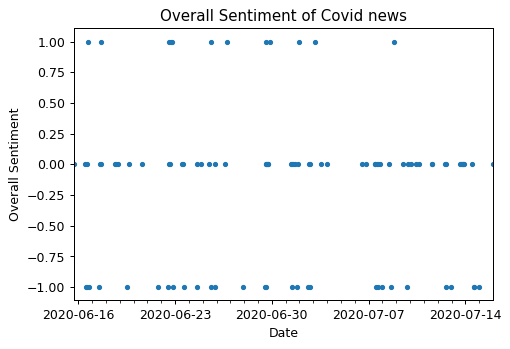

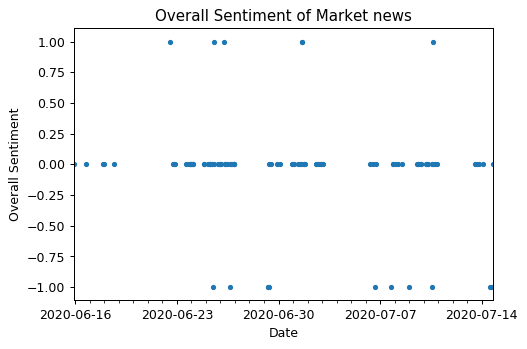

In [131]:
plotRes(df_covid, 'Covid')
plotRes(df_market, 'Market')

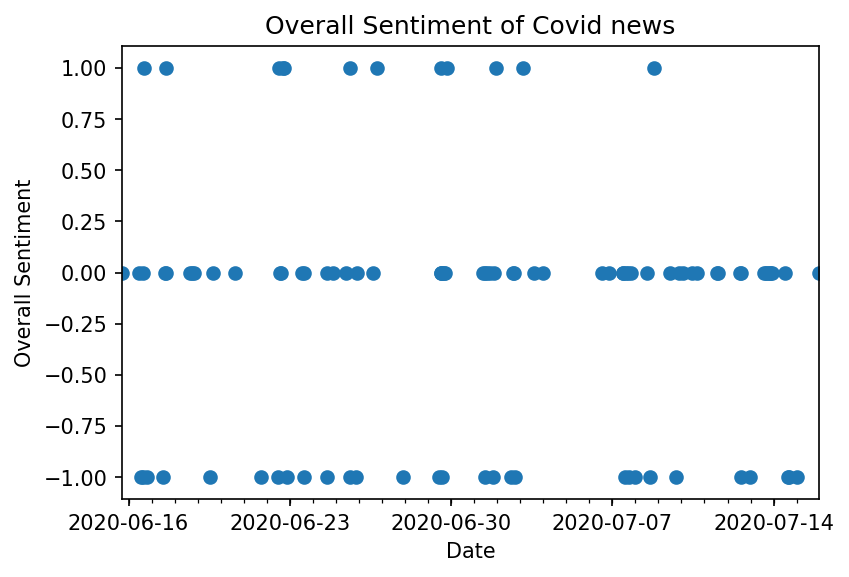

In [71]:
plotRes(df_covid, 'Covid')

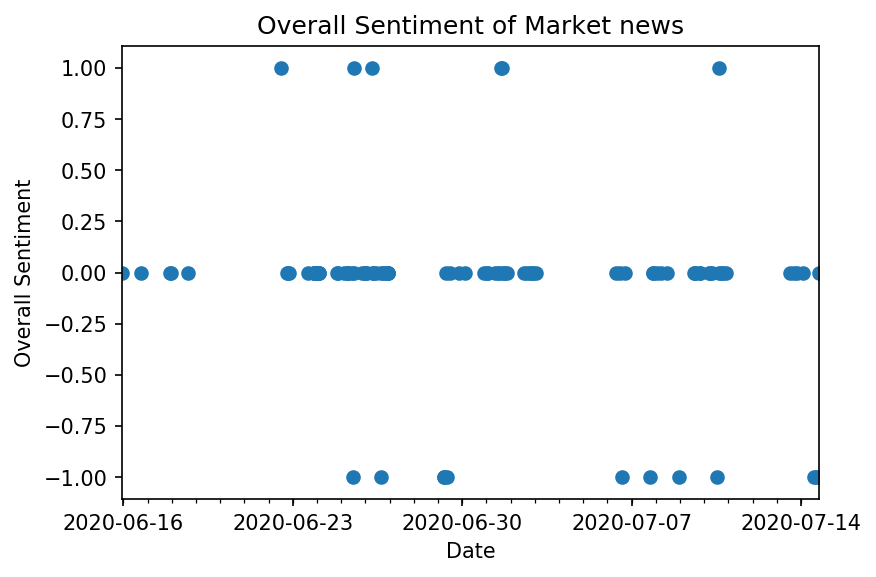

In [87]:
plotRes(df_market, 'Market')

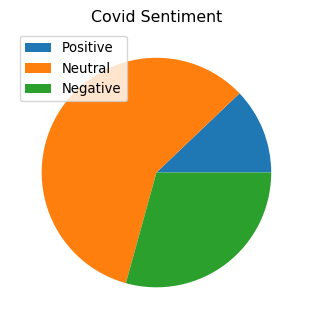

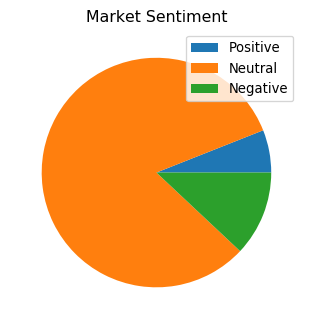

In [198]:
pieChart(df_covid, 'Covid')
pieChart(df_market, 'Market')

### Plots comparing Covid and Market news 

In [136]:
def plotCompareNews(df1, df2):
    # Compare the overall sentiment of two dfs filled with news results 
    # e.g. df1 hsa covid results and df2 has market results 
    
    if df1['publishedAt'][0] < df2['publishedAt'][0]:
        start_date = df1['publishedAt'][0]
    else:
        start_date = df1['publishedAt'][0]
        
    if df1['publishedAt'][len(df1) - 1] < df2['publishedAt'][len(df2) - 1]:
        end_date = df1['publishedAt'][len(df2) - 1]
    else:
        end_date = df1['publishedAt'][len(df1) - 1]
        
    
    # Plot scatter graph
    fig, ax = plt.subplots()
    plt.scatter(df1['publishedAt'].values, df1['Overall Sentiment'].values, s = 5, c = 'red', marker = 'x', label = 'Covid news')
    plt.scatter(df2['publishedAt'].values, df2['Overall Sentiment'].values, s = 5, c = 'blue', marker='o', label = 'Stock news')
    
    # Plot size
    plt.rcParams['figure.dpi'] = 95
    
    # Set labels and limits
    ax.set_xlim([start_date, end_date])
    ax.set_xlabel('Date')
    ax.set_ylabel('Overall Sentiment')
    ax.set_title('Comparing the overall sentiment of Covid and Market news')
    plt.legend(bbox_to_anchor=(1.05, 1))
    
    # Format x axis dates
    format_dates(ax)
    
    plt.show()



Results:

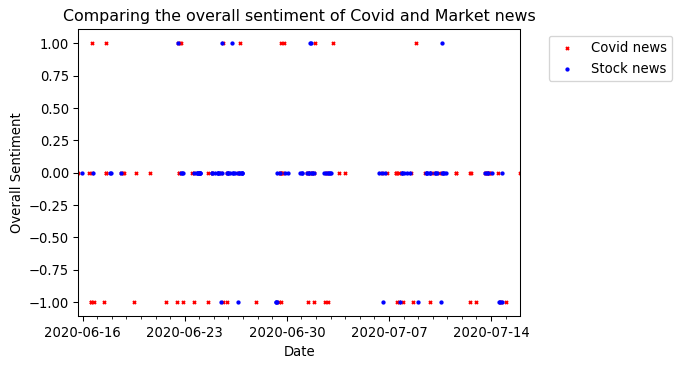

In [137]:
plotCompareNews(df_covid, df_market)

### Compare Covid news sentiment against market stock prices (June-July 2020)

In [199]:
def compareMarketandCovid(df_c, market_data_file):
    # Read Market data csv into a pandas df and format
    md_df = pd.read_csv(market_data_file)
    headers = md_df.columns
    date_col = headers[0]
    
    # Change date col to datetime objs and set as index
    md_df[date_col] = pd.to_datetime(md_df[date_col])
    md_df = md_df.set_index(keys = date_col, drop = True)
    
    # Only compare for dates where we have sentiment analysis of news
    start_date = df_c['publishedAt'][0]
    end_date = df_c['publishedAt'][len(df_c['publishedAt']) - 1]
    
    # Plot
    fig, ax = plt.subplots()
    lines = plt.plot(md_df)
    for i in range(0, len(md_df.columns)):
        lines[i].set_label(md_df.columns[i])
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
    plt.tight_layout()

    # plt.legend(md_df.columns, bbox_to_anchor=(1.05, 1))
    ax2 = ax.twinx()
    plt.scatter(df_c['publishedAt'].values, df_c['Overall Sentiment'].values, c='purple', marker='x',
                label='Covid news sentiments')

    # Display a legend to help navigate the graph
    ax.set_xlim([start_date, end_date])
    ax.set_xlabel('Date')
    ax.set_ylabel('Stock Price')
    ax2.set_ylabel('Overall Sentiment')
    ax.set_title('Comparing Stock Price and Overall Sentiment of Covid news')

    # Format x axis dates
    format_dates(ax)

    plt.legend(loc=9, bbox_to_anchor=(0.8, -0.1))

    plt.show()

Results:

Stock prices of certain S&P index tracker funds are on the left hand y axis.

Sentiment is shown on the right hand y axis:
- Positive = 1
- Neutral = 0
- Negative = -1

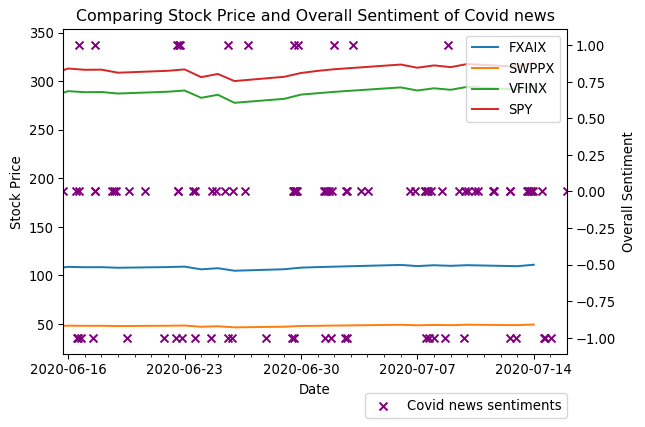

In [200]:
compareMarketandCovid(df_covid, market_data_file)

Most of the Covid articles we pulled for the past month have neutral sentiment. The neutral sentiment paired with the short time period mathces with the only small fluctations in the stock prices. 
At around the 23rd June, there are more negative news articles surrounding Covid and we can see a slight drop in the stock prices of 'VFINX' and 'SPY'. 

###  Correlations

In [5]:
def pcorr(df, size = 2):
    #size = len(df)
    corr = df.corr()
    
    fig, ax = plt.subplots(figsize = (size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)

In [55]:
df_test = df_covid.copy()
df_testm = df_market.copy()

In [56]:
df_test['publishedAt'] = df_test['publishedAt'].apply(lambda date: date.date())
df_testm['publishedAt'] = df_testm['publishedAt'].apply(lambda date: date.date())

In [216]:
# Average sentiment against date
dates = df_test['publishedAt'].unique()

df_new = pd.DataFrame(columns = ['Date', 'Sentiment'])

for idx, date in enumerate(dates):
    sent = df_test.groupby('publishedAt').get_group(date)['Overall Sentiment'].mean()
    df_new.loc[len(df_new)] = [date, sent]
    
df_new

,Date,Sentiment
0,2020-06-15,0.000000
1,2020-06-16,-0.333333
2,2020-06-17,0.000000
3,2020-06-18,0.000000
4,2020-06-19,-0.500000
5,2020-06-20,0.000000
6,2020-06-21,-1.000000
7,2020-06-22,0.142857
8,2020-06-23,-0.333333
9,2020-06-24,-0.333333


In [37]:
df_sent = pd.DataFrame()
df_sent['Overall Sentiment Covid'] = df_covid['Overall Sentiment']
df_sent['Overall Sentiment Market'] = df_market['Overall Sentiment']

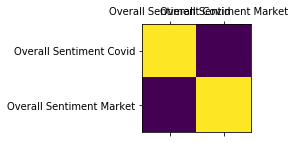

In [38]:
pcorr(df_sent)